In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,semilogx,semilogy

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [3]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [4]:
files = glob('Cappello/Spinel_Barite/roi*.dat')
cnb_hcs = MixPhase([spinel,barite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(16).raw_snip(m=64)
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

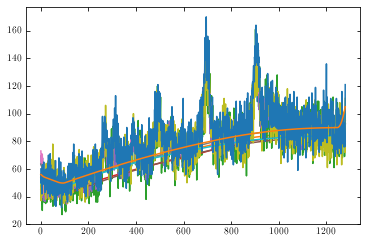

In [5]:
for s in xrd_spectra:
    plot(s.raw_intensity)
    plot(s.raw_snip)

[ 0.61668835  0.98396152  3.3059582   1.         -0.1045543   0.22211157
  0.74289857  0.24825128  0.4184401   0.64742555  0.33862592  0.67203675
 -1.93807437  1.          2.21232863  0.23198475  1.58800001  0.92256356
  0.41999935  1.53194747  1.         -2.91614559  4.39883705  2.15598923
  0.94517602  0.25043635 -0.31739022  0.87044404]


(19.0, 53.0)

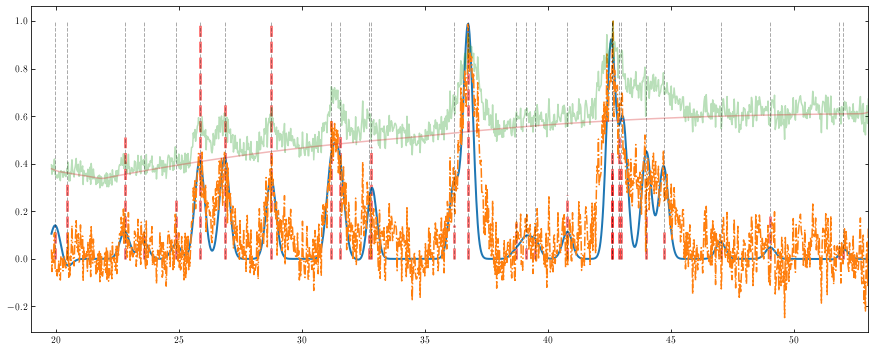

In [6]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
plot(s.theta,s.raw_intensity/s.raw_intensity.max(),'-',alpha=0.33)
plot(s.theta,s.raw_snip/s.raw_intensity.max(),'-',alpha=0.33)
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

[-1213.20528527    51.66346478  1953.69331296] [9.76846656]
[-1219.88753292    51.66346478  1963.43877683] [9.81719388]
[-1213.00678037    51.66346478  1947.49407226] [9.73747036]
[-1216.20358093    51.66346478  1953.20611193] [9.76603056]
[-1218.83826628    51.66346478  1958.20701359] [9.79103507]
[-1216.40104114    51.66346478  1957.27350296] [9.78636751]


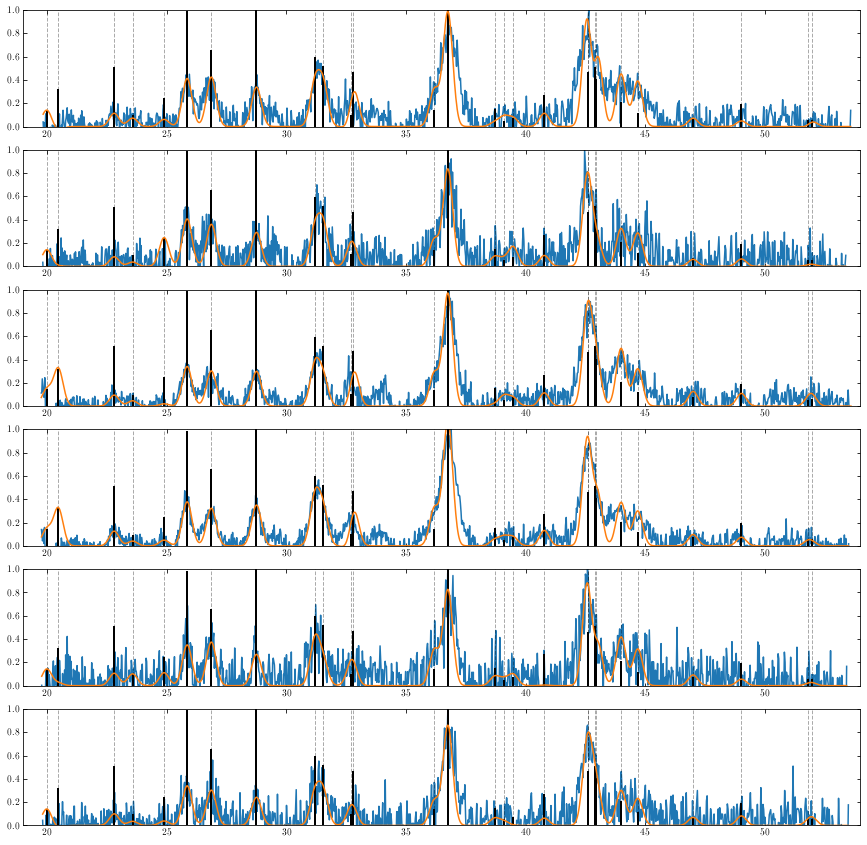

In [12]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=1)
    print(gn.spectra.opt,gn.spectra.s*5e-3)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1213.20528527    51.66346478  1953.69331296] [-1214.71937795    51.66346478  1952.71389334]
[-1219.88753292    51.66346478  1963.43877683] [-1214.71937795    51.66346478  1952.71389334]
[-1213.00678037    51.66346478  1947.49407226] [-1214.71937795    51.66346478  1952.71389334]
[-1216.20358093    51.66346478  1953.20611193] [-1214.71937795    51.66346478  1952.71389334]
[-1218.83826628    51.66346478  1958.20701359] [-1214.71937795    51.66346478  1952.71389334]
[-1216.40104114    51.66346478  1957.27350296] [-1214.71937795    51.66346478  1952.71389334]


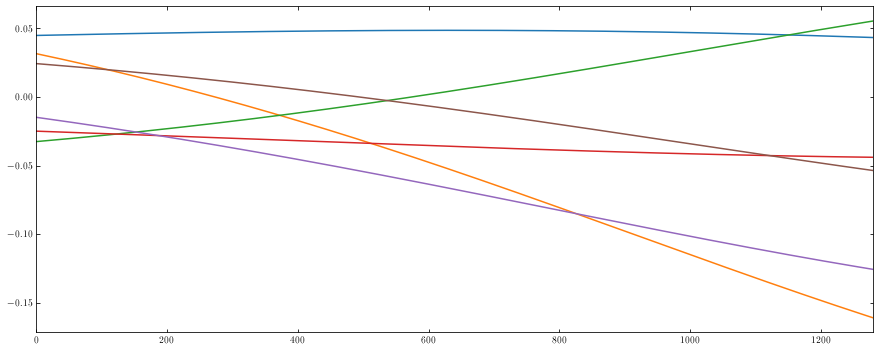

In [13]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)


(0.0, 1280.0)

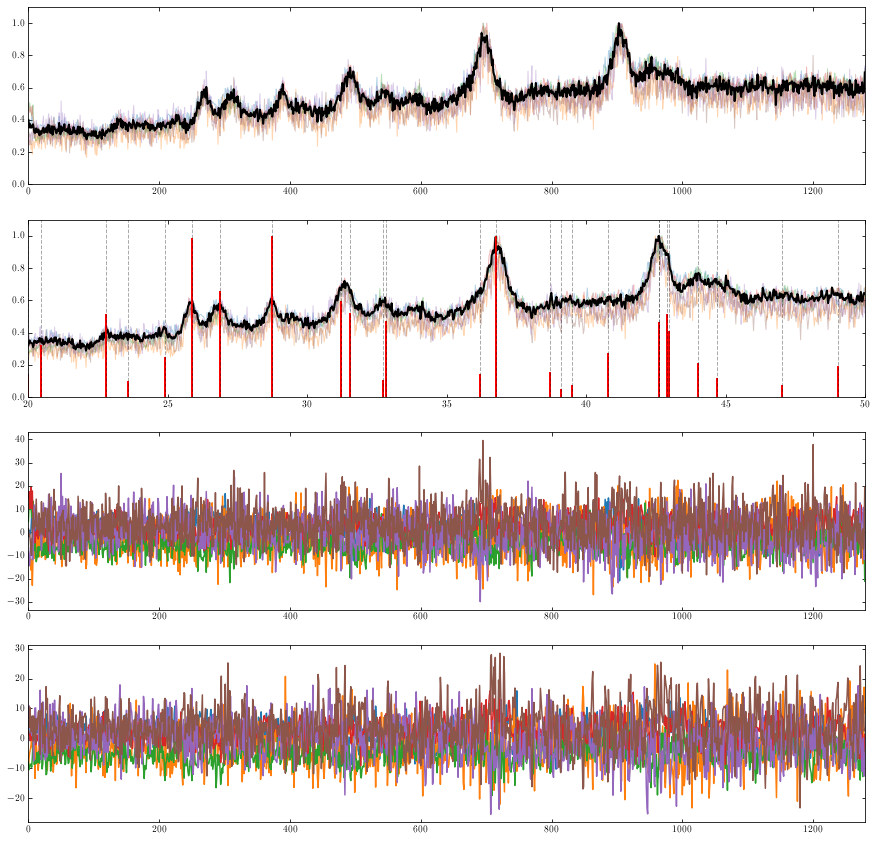

In [14]:
fig,ax = subplots(4,1,figsize=(15,15))

x = linspace(20,50,1280)
z0 = zeros(1280)
lenx = len(x)
z = zeros(len(x))

for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ax[0].plot(s.channel,s.raw_intensity/s.raw_intensity.max(),alpha=0.33,lw=1)
    z0 += s.raw_intensity
z0 /= len(xrd_gn)
ax[0].plot(s.channel,z0/z0.max(),'k',lw=2)
ax[0].set_xlim(0,1280)
ax[0].set_ylim(0,1.1)

for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    fce_i1d = interp1d(s.theta,s.raw_intensity,fill_value='extrapolate')
    y = fce_i1d(x)
    s.y = y
    ax[1].plot(x,y/y.max(),alpha=0.33,lw=1)
    z += y
z /= len(xrd_gn)
    
ax[1].plot(x,z/z.max(),'k-',lw=2)
ax[1].set_xlim(20,50)
ax[1].set_ylim(0,1.1)

x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
ax[1].vlines(x,0,y,'r',lw=2)
ax[1].vlines(x,0,1.1,'k',lw=1,ls='--',alpha=0.33)

h0 = []
std0 = []
mean0 = []
for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ds = s.raw_intensity - z0
    ax[2].plot(ds)
    h0 += [histogram(ds,bins=200,range=(-40,40))]
    std0 += [ds.std()]
    mean0 += [ds.mean()]
ax[2].set_xlim(0,1280)

h1 = []
std1 = []
mean1 = []
for i,(gn,s) in enumerate(zip(xrd_gn,xrd_spectra)):
    ds = s.y - z
    h1 += [histogram(ds,bins=200,range=(-40,40))]
    std1 += [ds.std()]
    mean1 += [ds.mean()]
    ax[3].plot(ds)
ax[3].set_xlim(0,lenx)

(0.0, 5.0)

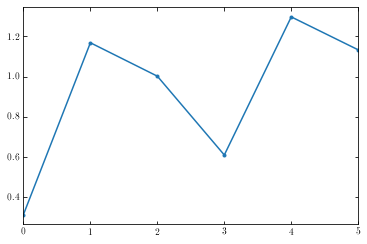

In [15]:
plot(array(std0)-array(std1),'.-')
xlim(0,5)

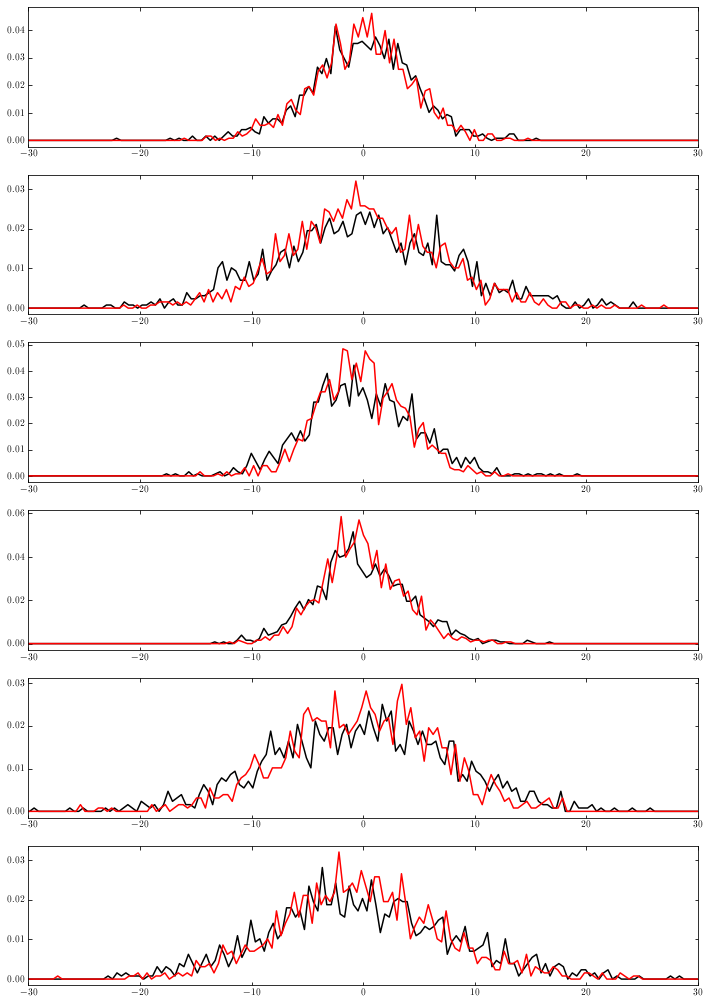

In [16]:
fig,ax = subplots(6,1,figsize=(12,18))
for i,((h,b),m) in enumerate(zip(h0,mean0)):
    b = b[:-1]
    ax[i].plot(b-m,h/h.sum(),'k-')
    
for i,((h,b),m) in enumerate(zip(h1,mean1)):
    b = b[:-1]
    ax[i].plot(b-m,h/h.sum(),'r-')
    ax[i].set_xlim(-30,30)